# Using Simulated Argus Data

In this notebook we look at how we can run simulations using a simulated survey file from the [Argus Array](https://argus.unc.edu/). This file uses (private) survey files that are not yet available for download.

**NOTE:** The `ArgusHealpixObsTable` is still in prototype and should not be used for scientific analysis until it is verified.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import Passband, PassbandGroup
from lightcurvelynx.astro_utils.snia_utils import DistModFromRedshift, X0FromDistMod
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.math_nodes.ra_dec_sampler import ApproximateMOCSampler
from lightcurvelynx.models.sncosmo_models import SncosmoWrapperModel
from lightcurvelynx.obstable.argus_obstable import ArgusHealpixObsTable
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.utils.plotting import plot_lightcurves

## Argus Survey Data

We start by loading an simulated argus survey file. Unlike the other survey tables, Argus stores information indexed by healpix. Each entry contains the information for a single healpix and time (epoch). The example file we use ("argussim_hpx_6131.parquet") includes information for a single healpix tile.

In [2]:
table = pd.read_parquet(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "argussim_hpx_6131.parquet")
print(f"Loaded table with {len(table)} rows and columns: {table.columns.tolist()}")
table.head()

Loaded table with 2379615 rows and columns: ['ra', 'dec', 'alt', 'az', 'nside', 'masked', 'epoch', 'exptime', 'ratchnum', 'seeing', 'moon_alt', 'moon_frac', 'limmag', 'sky_brightness', 'distance', 'volume', 'nested', 'signal_electrons', 'readnoise', 'dark_electrons', 'sky_electrons', 'noise', 'sharpness']


,ra,dec,alt,az,nside,masked,epoch,exptime,ratchnum,seeing,...,sky_brightness,distance,volume,nested,signal_electrons,readnoise,dark_electrons,sky_electrons,noise,sharpness
healpix,,,,,,,,,,,,,,,,,,,,,
6131,89.83966,34.272703,85.944664,333.864238,32,False,52222.409375,60.0,35,0.804956,...,21.426368,179.419602,4.703139e+06,1,210.638797,2.980317,0.405696,243.357877,21.524048,0.325367
6131,89.83966,34.272703,85.944664,333.864238,32,False,52222.410069,60.0,35,0.804956,...,21.426368,179.419602,4.703139e+06,1,210.638797,2.980317,0.405696,243.357877,21.524048,0.325367
6131,89.83966,34.272703,85.944664,333.864238,32,False,52222.410764,60.0,35,0.804956,...,21.426368,179.419602,4.703139e+06,1,210.638797,2.980317,0.405696,243.357877,21.524048,0.325367
6131,89.83966,34.272703,85.944664,333.864238,32,False,52222.411458,60.0,35,0.804956,...,21.426368,179.419602,4.703139e+06,1,210.638797,2.980317,0.405696,243.357877,21.524048,0.325367
6131,89.83966,34.272703,85.944664,333.864238,32,False,52222.412153,60.0,35,0.804956,...,21.426368,179.419602,4.703139e+06,1,210.638797,2.980317,0.405696,243.357877,21.524048,0.325367


We can use the `ArgusHealpixObsTable` class to transform the simulated data into an `ObsTable` data structure that can be used with LightCurveLynx's simulation infrastructure. This class performs several important preprocessing steps including: 1) Mapping the column names to standard names, 2) deriving noise information (zero points), and 3) building spatial data structures for fast querying.

Currently there are a few restrictions in the `ArgusHealpixObsTable` class that can be relaxed if needed. Primarily all entries are required to use the same healpix order (nside).

After loading the table, we plot the footprint on the sky.

ObsTable has 2379615 rows and columns: ['healpix', 'ra', 'dec', 'alt', 'az', 'nside', 'masked', 'time', 'exptime', 'ratchnum', 'seeing', 'moon_alt', 'moon_frac', 'maglim', 'skybrightness', 'distance', 'volume', 'nested', 'signal_electrons', 'readnoise', 'dark_electrons', 'sky_electrons', 'noise', 'sharpness', 'filter', 'zp']


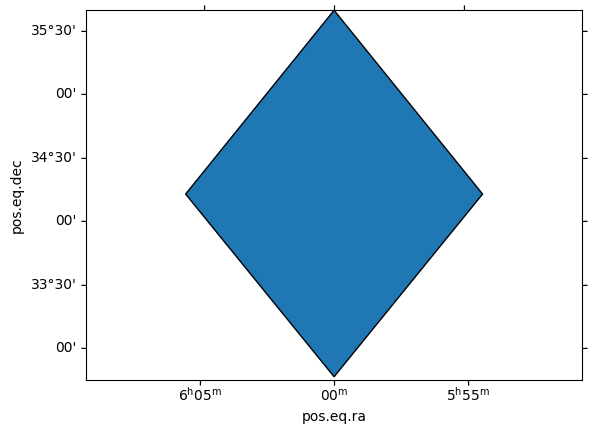

In [3]:
ops_data = ArgusHealpixObsTable(table)
print(f"ObsTable has {len(ops_data)} rows and columns: {ops_data.columns.tolist()}")
ops_data.plot_footprint()

We derive a zero point from a variety of factors including the limiting magnitude, exposure time, seeing, data electrons, and sky electrons. This is currently an approximation and we will need to work with the Argus team to best capture how to survey characteristics.

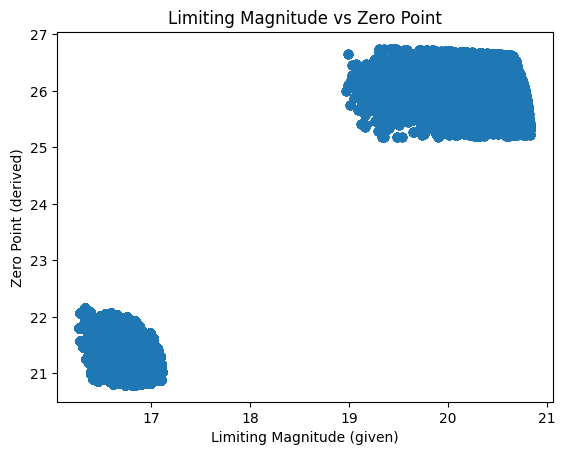

In [4]:
plt.scatter(
    ops_data["maglim"].to_numpy(),
    ops_data["zp"].to_numpy(),
    alpha=0.5,
)
plt.xlabel("Limiting Magnitude (given)")
plt.ylabel("Zero Point (derived)")
plt.title("Limiting Magnitude vs Zero Point")
plt.show()

By the survey's nature the Argus data has a huge number of observations.

In [5]:
t_min, t_max = ops_data.time_bounds()
print(f"Found {len(ops_data)} observations in time range [{t_min}, {t_max}]")

Found 2379615 observations in time range [51544.0875, 53370.44097222222]


For the purposes of this notebook, we are going to just use 90 days worth of data.  The `filter_rows()` handles updating the observation table so as to keep all the metadata current.

In [6]:
t_max = t_min + 90
time_mask = ops_data["time"] <= t_max
ops_data.filter_rows(time_mask)

print(f"After filtering to 90 days, {len(ops_data)} observations remain in time range [{t_min}, {t_max}]")

After filtering to 90 days, 149235 observations remain in time range [51544.0875, 51634.0875]


## Filter Information

The second piece of survey information that we need to run the simulation is the filter information. For this notebook, we will use custom 'g' filter provided by the argus team.

Note that for efficiency, the `Passband` class will automatically trim the transmission curve to only keep the central 99.8% of the data. So, while the file specifies wavelengths from 3,000 A to 10,000 A, the stored data will only cover the range of 3,620 A to 5,270 A. This setting can be adjusted using the `trim_quantile` argument, such as setting it to 1e-8 to get almost the full range.

Loaded g-band passband with wave range 3620.0-5270.0 Angstroms.


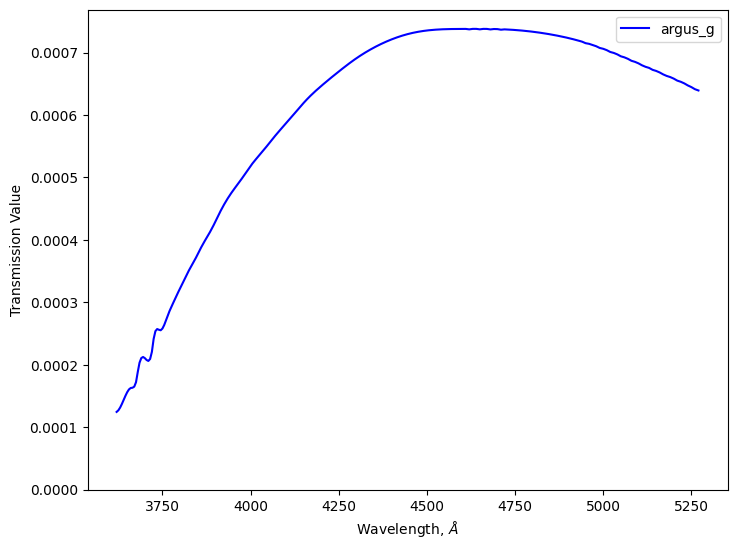

In [7]:
# Load the g-band passband for Argus from a given file.
g_passband = Passband.from_file(
    "argus",  # survey name
    "g",  # filter name
    table_path=_LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "argus_g_wav.parquet",
    units="nm",
)
print(f"Loaded g-band passband with wave range {g_passband.waves[0]}-{g_passband.waves[-1]} Angstroms.")

# Create a PassbandGroup with only the g-band and plot it.
pb_group = PassbandGroup([g_passband])
pb_group.plot()

The combination of the observations table and the bandpass filter provide all the survey information we need for the simulation. Next up is the model itself.

## Create the model

To generate simulated light curves we need to define the properties of the object from which to sample. In this notebook, we use [sncosmo](https://sncosmo.readthedocs.io/en/stable/)'s SALT2 model for Type Ia supernova. 

We start with "sampler" nodes that specify the distribution from which we would like to sample the object's parameters. We use the survey data to generate a multi-order coverage map of the survey footprint and sample (RA, dec) from that footprint. We sample redshift uniformly from [0.001, 0.2].

In [8]:
ra_dec_sampler = ApproximateMOCSampler.from_obstable(ops_data, depth=ops_data.depth)
redshift_sampler = NumpyRandomFunc("uniform", low=0.01, high=0.2)

We compute the physical parameters as follows:

In [9]:
# Use given values the cosmological parameters (H0=73.0, Omega_m=0.3).
# Then compue the distance modulus from the redshift (taking the redshift sampler as input).
distmod_func = DistModFromRedshift(redshift_sampler, H0=73.0, Omega_m=0.3)

# Sample x1, c, and m_abs from distributions motivated by typical SNIa values.
x1_func = NumpyRandomFunc("normal", loc=0, scale=2.0)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)

# Compute x0 from the other parameters using the standard Tripp formula,
# and the distance modulus from above.
x0_func = X0FromDistMod(
    distmod=distmod_func,  # Use the computed distance modulus from redshift as input.
    x1=x1_func,  # Use the sampled x1 values as input.
    c=c_func,  # Use the sampled c values as input.
    alpha=0.14,  # Use a constant alpha value motivated by typical SNIa fits.
    beta=3.1,  # Use a constant beta value motivated by typical SNIa fits.
    m_abs=m_abs_func,  # Use the sampled m_abs values as input.
)

# t0 for the super nova is sampled uniformly over the time range of the observations.
t0_func = NumpyRandomFunc("uniform", low=t_min, high=t_max)

Note that for more realistic surveys, we would likely want to first sample the host galaxy's properties (using something like [pzflow](https://jfcrenshaw.github.io/pzflow/) to define its parameters) and then sample the SALT2 parameters based on the host's details. In general, LightCurveLynx provides the ability to define a complex directed acyclic graph (DAG) of parameters.

We then define the model using the `SncosmoWrapperModel` class. All of the parameters are set using the samplers defined above.

In [10]:
source = SncosmoWrapperModel(
    "salt2-h17",  # Model name
    t0=t0_func,
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=ra_dec_sampler.ra,
    dec=ra_dec_sampler.dec,
    redshift=redshift_sampler,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The light curves are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. 

In [11]:
lightcurves = simulate_lightcurves(
    source,  # The model we are simulating.
    100,  # The number of simulations to run,
    ops_data,  # The observation table
    pb_group,  # The passband group (which includes the g-band passband we loaded).
    num_jobs=8,  # Use 8 workers to speed up the simulation.
)
lightcurves.head()

Simulating:   0%|          | 0/100 [00:00<?, ?obj/s]/Users/jkubica/h/lightcurvelynx/src/lightcurvelynx/models/physical_model.py:531: UserWarning: Some times are less than the model's defined bounds and no time extrapolation is set. If this is not the intended, you can enable time extrapolation using the 'time_extrapolation' parameter.
  warnings.warn(
/Users/jkubica/h/lightcurvelynx/src/lightcurvelynx/models/physical_model.py:558: UserWarning: Some times are greater than the model's defined bounds and no time extrapolation is set. If this is not the intended, you can enable time extrapolation using the 'time_extrapolation' parameter.
  warnings.warn(
Simulating:   1%|          | 1/100 [00:00<01:27,  1.13obj/s]/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
Simulating: 100%|██████████| 100/100 [01:04<00:00,  1.54obj/s]


id         ra        dec    nobs            t0         z  \
0   0  89.124129  33.927134  149235  51565.402353  0.059587   
1   1  89.637750  34.567358  149235  51570.881516  0.035458   
2   2  90.047262  35.438810  149235  51552.854729  0.193723   
3   3  90.205105  34.813170  149235  51582.361900  0.121907   
4   4  89.853540  34.652467  149235  51610.404817  0.079529   

                                              params  \
0  {'ApproximateMOCSampler:uniform_1.ra': 89.1241...   
1  {'ApproximateMOCSampler:uniform_1.ra': 89.6377...   
2  {'ApproximateMOCSampler:uniform_1.ra': 90.0472...   
3  {'ApproximateMOCSampler:uniform_1.ra': 90.2051...   
4  {'ApproximateMOCSampler:uniform_1.ra': 89.8535...   

                                          lightcurve  
0  [{mjd: 51587.26875, filter: 'g', flux: 66035.0...  
1  [{mjd: 51587.26875, filter: 'g', flux: 75026.4...  
2  [{mjd: 51587.26875, filter: 'g', flux: 1383.42...  
3  [{mjd: 51587.26875, filter: 'g', flux: 70720.5...  
4  [{mjd: 51587.26875, filter: 'g', flux: -1360.8...

Now let's plot some random light curves

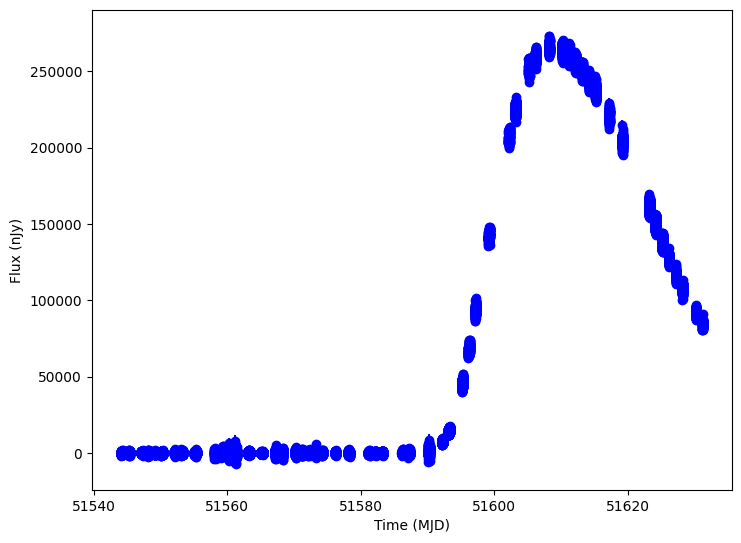

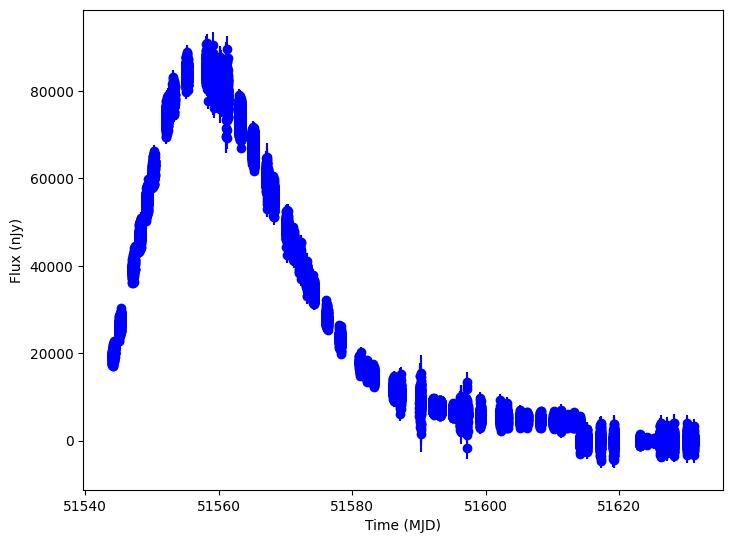

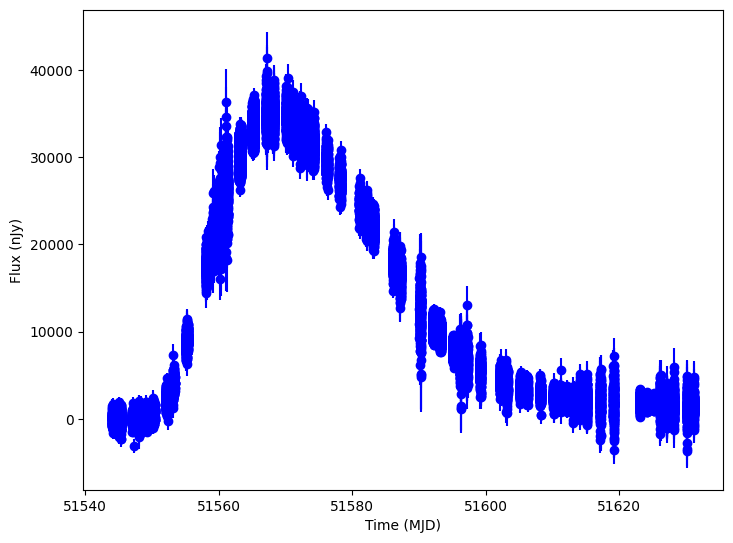

In [12]:
lightcurves = lightcurves.dropna(subset=["lightcurve"])
random_ids = np.random.choice(len(lightcurves), 3)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.iloc[random_id]

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
    )